This tutorial illustrates the 1D example presented in Chapter 1:

A one-dimension beam, with Young modulus $E$, and length $L=1$, is solicited in tension. 
For the sake of simplicity, this problem is limited to one degree of freedom, in which the displacement is observed and affected by measurement noise. 
The constitutive relation is : 
\begin{align}
    \sigma &= E \epsilon 
\end{align}

and $E$ needs to be identified.

In [2]:
import torch
import matplotlib.pyplot as plt


In [3]:
E_true = 1  # Young modulus
F_imposed = torch.linspace(0, 140, 10)  # 100 loadings uniformly distributed between 0 and 140

First, we need to create the functions to generate the data needed for training. 
To help the understanding, the Latin method (which will be adapted to perform the Step 1 of the mCRE training) is used to generate the data. 

In [4]:
  # Import of the function used to integrate evolutions laws

def generate_data(E, F_imposed):
    """
    This function simulates the true model in order to generate the data need for the training.
    Input: 
        - E: Young modulus
        - F_imposed: torch.tensor containing all the values of the imposed force at each time step.
    Output:
        - eps_elastic: elastic strain (torch.tensor containing the values at each time step)
        - sigma: stress (torch.tensor containing the values at each time step)
    """
    
   
     ## Iteration 0 (elastic initialisation)
    eps_elastic = F_imposed / E 
    sigma = E * eps_elastic

    return eps_elastic, sigma 

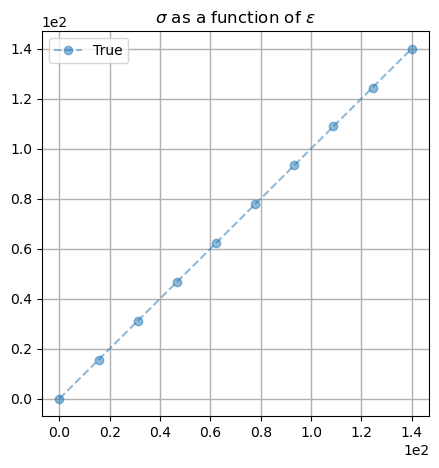

In [5]:
from plot_utils import plot_solution

eps_elastic_true, sigma_true = generate_data(E_true, F_imposed)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_solution(axs, sigma_true, eps_elastic_true, label='True')
plt.show()


Now, let's add some noise on the data.

In [6]:
noise_level = 1e-2

mean = torch.abs(eps_elastic_true).mean()
noise = torch.normal(std=noise_level * mean * torch.ones_like(eps_elastic_true), mean=0)
eps_elastic_true_noisy = eps_elastic_true + noise

Now, let's minimize the mCRE to update the hardening modulus

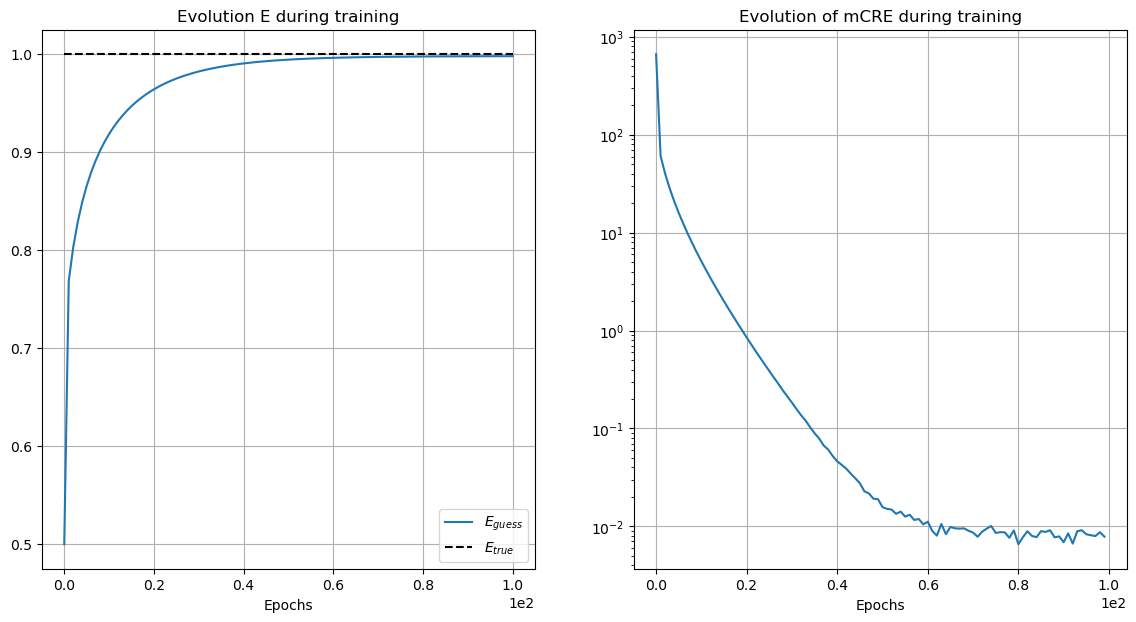

In [7]:
from utils import step_1_mcre, compute_loss, update_E
from plot_utils import plot_evolution_training


# Here we assume that we know the right Young modulus and initial elastic limit

E_guess = E_true / 2


# Parameters for the optimization (in the full version of the method this parameters are automatically updated)
lr = 1e-4
alpha = 1e-2
nb_iter_mcre =  100

# List to store the values of loss function and parameters to be updated
list_mcre = []
list_E_guess = [E_guess]

for iter_mcre in range(0, nb_iter_mcre):
    # Step 1 of mCRE: (details in the function)
    eps_elastic_U, sigma_U, eps_elastic_V, sigma_V = step_1_mcre(E_guess, F_imposed, eps_elastic_true_noisy, alpha)
    
    # Computation of the mCRE
    dd_loss, cre_elastic = compute_loss(eps_elastic_true_noisy, E_guess, eps_elastic_U, eps_elastic_V, sigma_V)
    
    
    list_mcre.append(dd_loss*alpha+cre_elastic)
    
    # Update of parameter h with a gradient descent step
    E_guess = update_E(eps_elastic_U, eps_elastic_V, E_guess, lr)
    list_E_guess.append(E_guess)

    
plot_evolution_training(list_E_guess, E_true, list_mcre)

    

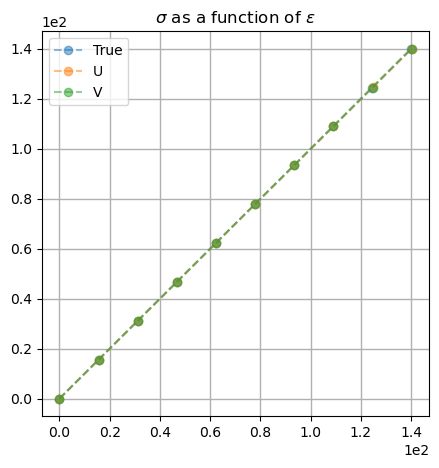

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_solution(axs, sigma_true, eps_elastic_true, label='True')
plot_solution(axs, sigma_U, eps_elastic_U, label='U')
plot_solution(axs, sigma_V, eps_elastic_V, label='V')
plt.show()

Now let's switch to a sequential data assimilation paradigm with the MDKF framework !!